This notebook has porpuse of showing the dataset that we used, alongside the prediction of the different cosmological models that we analyzed.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.constants import c as c_luz #meters/seconds
from scipy.integrate import cumulative_trapezoid as cumulative_trapezoid
c_luz_km = c_luz/1000 #kilometers/seconds

import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_datos_global = os.path.dirname(path_git)

os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from solve_sys import Hubble_th as Hubble_th
from supernovae import aparent_magnitude_th, chi2_supernovae
from BAO import r_drag, Hs_to_Ds, Ds_to_obs_final
from AGN import zs_2_logDlH0
from chi_square import chi2_without_cov, all_parameters

Here we define the plotting function.

In [6]:
def plot_data(theta, fixed_params, index = 0,
                    dataset_SN_plus_shoes = None, dataset_SN_plus = None,
                    dataset_SN = None, dataset_CC = None,
                    dataset_BAO = None, dataset_AGN = None, dataset_BAO_odintsov = None,
                    H0_Riess = False, num_z_points = int(10**5), model='HS', n = 1,
                    nuisance_2 = False, close = False,
                    save_path = None):

    '''
    Plot the different data sets with the prediction of some cosmological model.
    '''

    [Mabs, omega_m, b, H_0] = all_parameters(theta, fixed_params, index)

    physical_params = [omega_m,b,H_0]
    zs_model, Hs_model = Hubble_th(physical_params, n=n, model=model,
                                z_min=0, z_max=10, num_z_points=num_z_points)
                                #AGN data goes up to higher redshift.
    Hs_interpol = interp1d(zs_model, Hs_model)
    int_inv_Hs = cumulative_trapezoid(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interpol = interp1d(zs_model, int_inv_Hs)

    if dataset_SN_plus_shoes != None:
        zhd, zhel, mb, mu_shoes, Cinv, is_cal = dataset_SN_plus_shoes #Import the data
        muobs = mb - Mabs
        muth_num = aparent_magnitude_th(int_inv_Hs_interpol, zhd, zhel) #Numeric prediction of mu
        muth = muth_num*(-is_cal + 1) + mu_shoes*(is_cal) #Merge num predicion with mu_shoes

        emu=np.sqrt(np.diag(np.linalg.inv(Cinv)))

        plt.figure()
        plt.grid()
        plt.title('Pantheon plus + SH0ES ({})'.format(model))
        #plt.title('Pantheon plus + SH0ES')
        plt.plot(zhd,muth,label='theory')
        plt.errorbar(zhd,muobs,emu,fmt='.', label='data')
        plt.legend()
        plt.xlabel('z (redshift)')
        plt.ylabel(r'$\mu$')
        plt.savefig(path_datos_global+'/data_PPS.pdf')
        if close==True:
            plt.close()

    if dataset_SN_plus != None:
        zhd, zhel, Cinv, mb = dataset_SN_plus
        muobs =  mb - Mabs
        emu=np.sqrt(np.diag(np.linalg.inv(Cinv)))
        muth = aparent_magnitude_th(int_inv_Hs_interpol, zhd, zhel)

        plt.figure()
        plt.grid()
        plt.title('Pantheon plus ({})'.format(model))
        plt.plot(zhd,muth,label='theory')
        plt.errorbar(zhd,muobs,emu,fmt='.', label='data')
        plt.legend()
        plt.xlabel('z (redshift)')
        plt.ylabel(r'$\mu$')
        if close==True:
            plt.close()

    if dataset_SN != None:
        zcmb, zhel, Cinv, mb = dataset_SN
        muth = aparent_magnitude_th(int_inv_Hs_interpol, zcmb, zhel)
        muobs =  mb - Mabs
        emu=np.sqrt(np.diag(np.linalg.inv(Cinv)))

        plt.figure()
        plt.grid()
        plt.title('Pantheon ({})'.format(model))
        plt.plot(zcmb,muth,label='theory')
        plt.errorbar(zcmb,muobs,emu,fmt='.', label='data')
        plt.legend()
        plt.xlabel('z (redshift)')
        plt.ylabel(r'$\mu$')
        if close==True:
            plt.close()


    if dataset_CC != None:
        z_data, H_data, dH = dataset_CC
        Hs_interpol = interp1d(zs_model, Hs_model)
        H_teo = Hs_interpol(z_data)

        plt.figure()
        plt.grid()
        plt.title('Cosmic Chronometers ({})'.format(model))
        #plt.title('Cosmic Chronometers')
        plt.plot(zs_model,Hs_model,label='theory')
        plt.errorbar(z_data,H_data,dH,fmt='.',label='data')
        plt.xlim([0,2.5])
        plt.ylim([0,400])
        plt.legend()
        plt.xlabel('z (redshift)')
        plt.ylabel(r'$H(z)\, [\frac{km/seg}{Mpc}]$')
        plt.savefig(path_datos_global+'/data_CC.pdf')
        if close==True:
            plt.close()

    if dataset_BAO != None:
        num_datasets=5
        legends_datasets = ['$D_A/r_d$','$D_H/r_d$','$D_M/r_d$','$D_V/r_d$','$H \cdot r_d$']
        for i in range(num_datasets): #For each datatype
            (z_data_BAO, valores_data, errores_data_cuad,wb_fid) = dataset_BAO[i]
            if i==0: #Da data
                rd = r_drag(omega_m,H_0,wb_fid) #Computation of rd
                distancias_teoricas = Hs_to_Ds(Hs_interpol, int_inv_Hs_interpol, z_data_BAO, i)
                output_th = Ds_to_obs_final(zs_model, distancias_teoricas, rd, i)
            else:
                distancias_teoricas = Hs_to_Ds(Hs_interpol, int_inv_Hs_interpol, z_data_BAO, i)
                output_th = np.zeros(len(z_data_BAO))
                for j in range(len(z_data_BAO)): #For each species
                     rd = r_drag(omega_m,H_0,wb_fid[j]) #Computation of rd
                     output_th[j] = Ds_to_obs_final(zs_model,distancias_teoricas[j],rd,i)
            #Chi square cumputation for each datatype (i)
            plt.figure()
            plt.title('{} ({})'.format(legends_datasets[i],model))
            plt.grid()
            plt.plot(z_data_BAO,output_th,'.',label='theory')
            plt.errorbar(z_data_BAO,valores_data,np.sqrt(errores_data_cuad),fmt='.',label='data')
            plt.legend()
            plt.xlabel('z (redshift)')
            if close==True:
                plt.close()

    if dataset_AGN != None:
        #Import the data
        z_data, logFuv, eFuv, logFx, eFx  = dataset_AGN

        #AGN parameters
        beta = 7.735
        ebeta = 0.244
        gamma = 0.648
        egamma = 0.007

        Es_model = Hs_model/H_0

        DlH0_teo = zs_2_logDlH0(int_inv_Hs_interpol(z_data)*H_0,z_data)
        DlH0_obs =  np.log10(3.24) - 25 + (logFx - gamma * logFuv - beta) / (2*gamma - 2)

        df_dgamma =  (-logFx+beta+logFuv) / (2*(gamma-1)**2)
        eDlH0_cuad = (eFx**2 + gamma**2 * eFuv**2 + ebeta**2)/ (2*gamma - 2)**2 + (df_dgamma)**2 * egamma**2 #Squared errors


        plt.figure()
        plt.grid()
        plt.title('AGN ({})'.format(model))
        plt.plot(z_data,DlH0_teo,'.',label='theory')
        plt.errorbar(z_data,DlH0_obs,np.sqrt(eDlH0_cuad),fmt='.',label='data')
        plt.legend()
        plt.xlabel('z (redshift)')
        if close==True:
            plt.close()

    if dataset_BAO_odintsov != None:
        #Import data
        z_data_BAO, H_data_BAO, dH_BAO, rd_fid = dataset_BAO_odintsov
        Hs_interpol = interp1d(zs_model, Hs_model)
        H_teo = Hs_interpol(z_data_BAO)

        H_data_BAO_norm = np.zeros(len(H_data_BAO))
        for i in range(len(H_data_BAO_norm)):
            if rd_fid[i]==1:
                factor = 1
            else:
                rd = r_drag(omega_m,H_0,wb=0.0225) #rd computation with fixed wb
                factor = rd_fid[i]/rd
            H_data_BAO_norm[i] = H_data_BAO[i] * factor

        plt.figure()
        plt.grid()
        plt.title('BAO Odintsov ({})'.format(model))
        plt.plot(z_data_BAO,H_teo,'.',label='theory')
        plt.errorbar(z_data_BAO,H_data_BAO_norm,dH_BAO,fmt='.',label='data')
        plt.legend()
        plt.xlabel('z (redshift)')
        if close==True:
            plt.close()


Here is a concrete example. First, we import the datasets.

In [7]:
os.chdir(path_git + '/fr_mcmc/utils/')
from data import read_data_pantheon_plus_shoes, read_data_pantheon_plus, read_data_pantheon, read_data_chronometers, read_data_BAO, read_data_AGN

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
dS_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                    'Pantheon+SH0ES_STAT+SYS.cov')

# Pantheon plus
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
dS_SN_plus = read_data_pantheon_plus('Pantheon+SH0ES.dat',
                            'covmat_pantheon_plus_only.npz')

# Pantheon
os.chdir(path_git+'/fr_mcmc/source/Pantheon/')
ds_SN = read_data_pantheon('lcparam_full_long_zhel.txt')

# Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')

# BAO
os.chdir(path_git+'/fr_mcmc/source/BAO/')
ds_BAO = []
archivos_BAO = ['BAO_data_da.txt','BAO_data_dh.txt','BAO_data_dm.txt',
                'BAO_data_dv.txt','BAO_data_H.txt']
for i in range(5):
    aux = read_data_BAO(archivos_BAO[i])
    ds_BAO.append(aux)

# AGN
os.chdir(path_git+'/fr_mcmc/source/AGN/')
ds_AGN = read_data_AGN('table3.dat')


Now, we call the ploting function

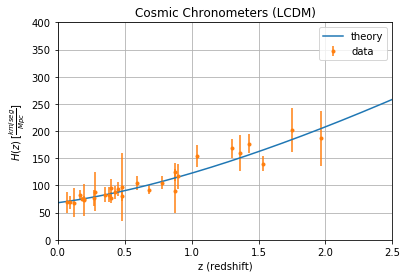

In [4]:
p1 = [0.3192770, 68.15502] #CC
p2 = [-19.24184, 0.3332519, 73.73002] #PPS

plot_data(p1, [_,_], index=22,
                #dataset_SN_plus_shoes = dS_SN_plus_shoes,
                #dataset_SN_plus = dS_SN_plus,
                #dataset_SN = ds_SN,
                dataset_CC = ds_CC,
                #dataset_BAO = ds_BAO,
                #dataset_AGN = ds_AGN,
                model = 'LCDM',
                close = False
                )

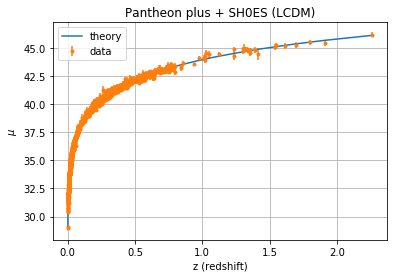

In [8]:
plot_data(p2, _, index=32,
                dataset_SN_plus_shoes = dS_SN_plus_shoes,
                #dataset_SN_plus = dS_SN_plus,
                #dataset_SN = ds_SN,
                #dataset_CC = ds_CC,
                #dataset_BAO = ds_BAO,
                #dataset_AGN = ds_AGN,
                model = 'LCDM',
                close = False
                )

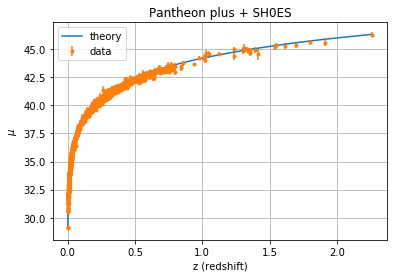

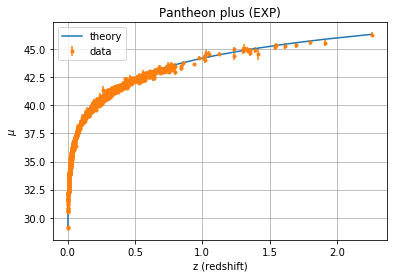

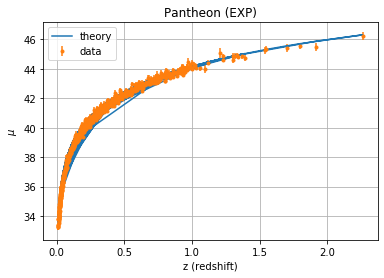

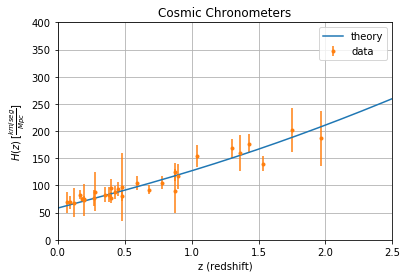

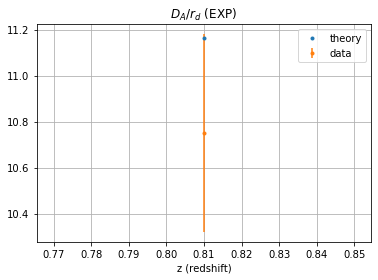

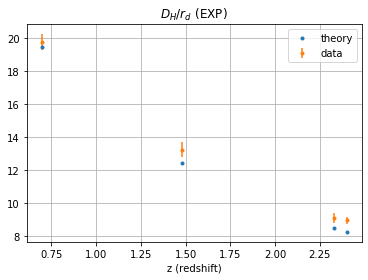

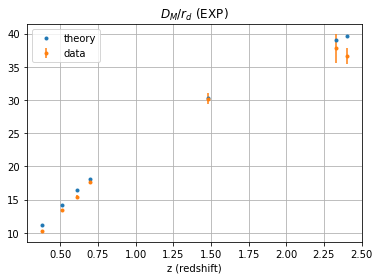

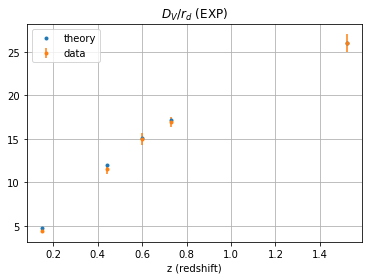

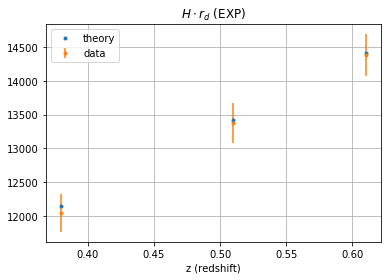

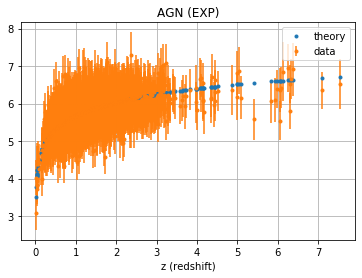

In [20]:
plot_data([-19.35, 0.30,5, 69.22], _, index=4,
                dataset_SN_plus_shoes = dS_SN_plus_shoes,
                dataset_SN_plus = dS_SN_plus,
                dataset_SN = ds_SN,
                dataset_CC = ds_CC,
                dataset_BAO = ds_BAO,
                dataset_AGN = ds_AGN,
                model = 'EXP',
                close = False
                )